In [136]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

from utils import Dataset

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo, list_available_datasets

In [220]:
import os
import pickle

def save_object(obj, filename):
    # Overwrites any existing file.
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def load_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
        return obj

# Regression

In [30]:
datasets_regression = {
    1: 'Abalone',
    9: 'Auto MPG',
    60: 'Liver Disorders',
    186: 'Wine Quality',
    189: 'Parkinsons Telemonitoring',
    275: 'Bike Sharing Dataset',
    477: 'Real estate valuation',
    519: 'Heart failure clinical records'  
}

Рассмотрим для примера какой-нибудь один датасет

In [42]:
# ==========================
data = fetch_ucirepo(id=1)
# ==========================
df = data.variables[['name', 'role', 'type']]
target = df[df.role == 'Target'].name.values[0]
columns = df[df.role == 'Feature'][['name', 'type']]
num_columns = columns.loc[(columns.type == 'Continuous') | (columns.type == 'Integer')].name.values
cat_columns = columns.loc[(columns.type == 'Categorical') | (columns.type == 'Binary')].name.values
columns = columns.name.values
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)
    
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('linreg', LinearRegression())
    ]
)

df = data.data.original

if data.metadata.has_missing_values:
    df = df.dropna(ignore_index=True)

X = df.drop(columns=[target])
y = df[target].to_numpy().flatten()
    
dataset = Dataset(X, y)
m, n = X.shape
sample_sizes = np.linspace(n+1, m, 21, dtype=int)[1:]
B = 100

model = pipe
loss = mean_squared_error

loss_means = []
loss_stds = []

for k in tqdm(sample_sizes):
    tmp = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model.fit(X_k, y_k)
        y_pred = model.predict(X)
        tmp.append(loss(y, y_pred))
    tmp = np.array(tmp)
    loss_means.append(tmp.mean())
    loss_stds.append(tmp.std())

loss_means = np.array(loss_means)
loss_stds = np.array(loss_stds)

100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


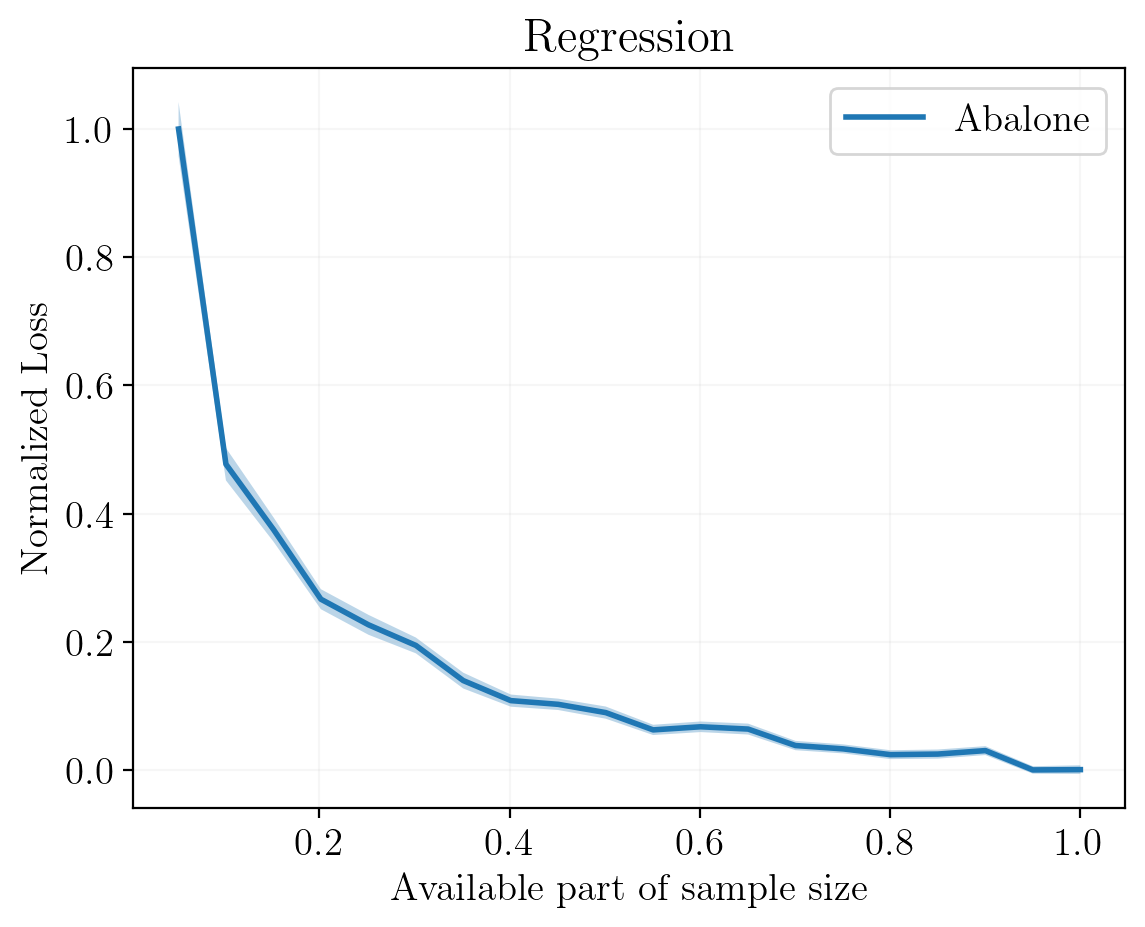

In [51]:
x_vals = sample_sizes / max(sample_sizes)
y_means = loss_means - min(loss_means)
y_means = y_means / max(y_means)
y_stds = loss_stds / max(loss_means)
#plt.plot(sample_sizes, loss_means, label=name)
#plt.fill_between(sample_sizes, loss_means - loss_stds, loss_means + loss_stds, alpha=0.3)
plt.plot(x_vals, y_means, label=data.metadata.name)
plt.fill_between(x_vals, y_means - y_stds, y_means + y_stds, alpha=0.3)

plt.legend()
plt.title("Regression")
plt.xlabel("Available part of sample size")
plt.ylabel("Normalized Loss")
#plt.xlim(left=55)
#plt.ylim(bottom=0, top=10000)
plt.show()

Теперь построим график для каждого датасета с задачей регрессии

In [215]:
results_regression = {}

for key in tqdm(datasets_regression.keys()):
    
    # ==========================
    data = fetch_ucirepo(id=key)
    # ==========================
    df = data.variables[['name', 'role', 'type']]
    target = df[df.role == 'Target'].name.values[0]
    columns = df[df.role == 'Feature'][['name', 'type']]
    num_columns = columns.loc[(columns.type == 'Continuous') | (columns.type == 'Integer')].name.values
    cat_columns = columns.loc[(columns.type == 'Categorical') | (columns.type == 'Binary')].name.values
    columns = columns.name.values
        
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
        ]
    )
        
    pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('linreg', LinearRegression())
        ]
    )

    df = data.data.original

    if data.metadata.has_missing_values:
        df = df.dropna(ignore_index=True)

    X = df.drop(columns=[target])
    y = df[target].to_numpy().flatten()
        
    dataset = Dataset(X, y)
    m, n = X.shape
    sample_sizes = np.linspace(n+1, m, 21, dtype=int)[1:]
    B = 100

    model = pipe
    loss = mean_squared_error

    loss_means = []
    loss_stds = []

    for k in sample_sizes:
        tmp = []
        for _ in range(B):
            X_k, y_k = dataset.sample(k)
            model.fit(X_k, y_k)
            y_pred = model.predict(X)
            tmp.append(loss(y, y_pred))
        tmp = np.array(tmp)
        loss_means.append(tmp.mean())
        loss_stds.append(tmp.std())

    loss_means = np.array(loss_means)
    loss_stds = np.array(loss_stds)

    results_regression[data.metadata.name] = {}
    results_regression[data.metadata.name]['sample_sizes'] = sample_sizes
    results_regression[data.metadata.name]['mean'] = loss_means
    results_regression[data.metadata.name]['std'] = loss_stds

100%|██████████| 8/8 [03:58<00:00, 29.83s/it]


In [ ]:
#results_regression = load_object("plots/datasets_regression.pkl")

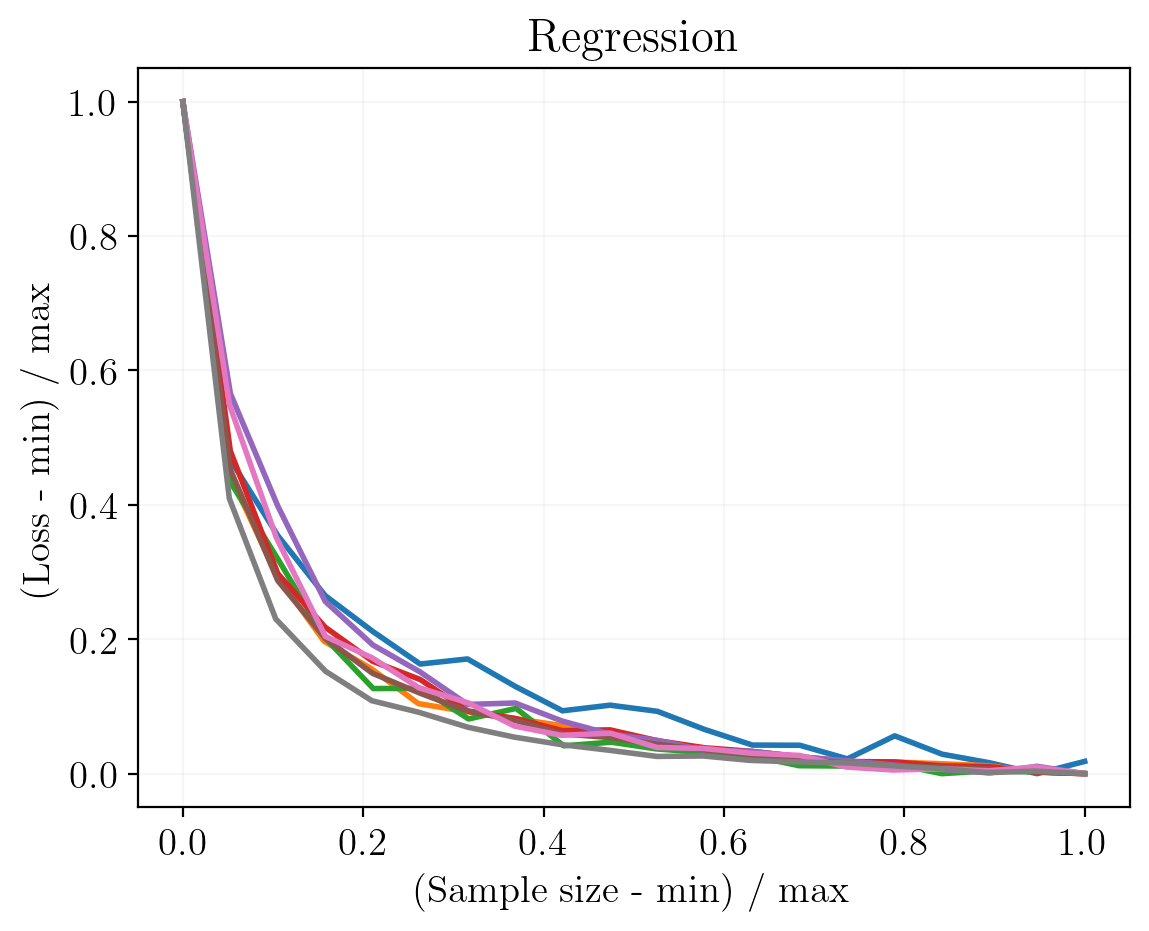

In [230]:
for name in results_regression.keys():
    sample_sizes = results_regression[name]['sample_sizes']
    loss_means = results_regression[name]['mean']
    loss_stds = results_regression[name]['std']
    x_vals = sample_sizes - min(sample_sizes)
    x_vals = x_vals / max(x_vals)
    y_means = loss_means - min(loss_means)
    y_means = y_means / max(y_means)
    y_stds = loss_stds / max(loss_means)
    #plt.plot(sample_sizes / max(sample_sizes), loss_means, label=name)
    #plt.fill_between(sample_sizes / max(sample_sizes), loss_means - loss_stds, loss_means + loss_stds, alpha=0.3)
    plt.plot(x_vals, y_means, label=name)
    plt.fill_between(x_vals, y_means - y_stds, y_means + y_stds, alpha=0.3)

#plt.legend()
plt.title("Regression")
#plt.xlabel("Available part of sample size")
#plt.ylabel("Loss")
plt.xlabel("(Sample size - min) / max")
plt.ylabel("(Loss - min) / max")
#plt.xlim(left=55)
#plt.ylim(bottom=0, top=10000)
#plt.savefig("figures/datasets_regression_stds.pdf", bbox_inches='tight')
plt.show()

In [221]:
#save_object(results_regression, "plots/datasets_regression.pkl")

# Classification

In [ ]:
datasets_classification = {
    #1: 'Abalone', не идут итерации цикла
    10: 'Automobile',
    17: 'Breast Cancer Wisconsin (Diagnostic)',
    19: 'Car Evaluation',
    27: 'Credit Approval',
    42: 'Glass Identification',
    #45: 'Heart Disease', похожа на линейную
    #46: 'Hepatitis', похожа на линейную
    52: 'Ionosphere',
    53: 'Iris',
    #59: 'Letter Recognition', очень долго
    #73: 'Mushroom', очень долго
    #94: 'Spambase', долго
    101: 'Tic-Tac-Toe Endgame',
    105: 'Congressional Voting Records',
    109: 'Wine',
    111: 'Zoo',
    #159: 'MAGIC Gamma Telescope', долго
    #186: 'Wine Quality', вроде не работает
    #468: 'Online Shoppers Purchasing Intention Dataset', очень долго
    519: 'Heart failure clinical records',
    #544: 'Estimation of obesity levels based on eating habits and physical condition', долго
    #697: "Predict students' dropout and academic success", долго
}

Рассмотрим для примера какой-нибудь один датасет

In [191]:
# ==========================
data = fetch_ucirepo(id=697)
# ==========================
df = data.variables[['name', 'role', 'type']]
target = df[df.role == 'Target'].name.values[0]
columns = df[df.role == 'Feature'][['name', 'type']]
num_columns = columns.loc[(columns.type == 'Continuous') | (columns.type == 'Integer')].name.values
cat_columns = columns.loc[(columns.type == 'Categorical') | (columns.type == 'Binary')].name.values
columns = columns.name.values
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)
    
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression())
    ]
)

df = data.data.original

if data.metadata.has_missing_values:
    df = df.dropna(ignore_index=True)

X = df.drop(columns=[target])
y = df[target].to_numpy().flatten()
    
dataset = Dataset(X, y, task='classification')
m, n = X.shape
start = max(n+1, len(dataset.labels)+1)
sample_sizes = np.linspace(start, m, 21, dtype=int)[1:]
B = 100

model = pipe
loss = log_loss

loss_means = []
loss_stds = []

for k in tqdm(sample_sizes):
    tmp = []
    for _ in range(B):
        X_k, y_k = dataset.sample(k)
        model.fit(X_k, y_k)
        y_pred = model.predict_proba(X)
        tmp.append(loss(y, y_pred, labels=dataset.labels))
    tmp = np.array(tmp)
    loss_means.append(tmp.mean())
    loss_stds.append(tmp.std())

loss_means = np.array(loss_means)
loss_stds = np.array(loss_stds)

100%|██████████| 20/20 [01:48<00:00,  5.44s/it]


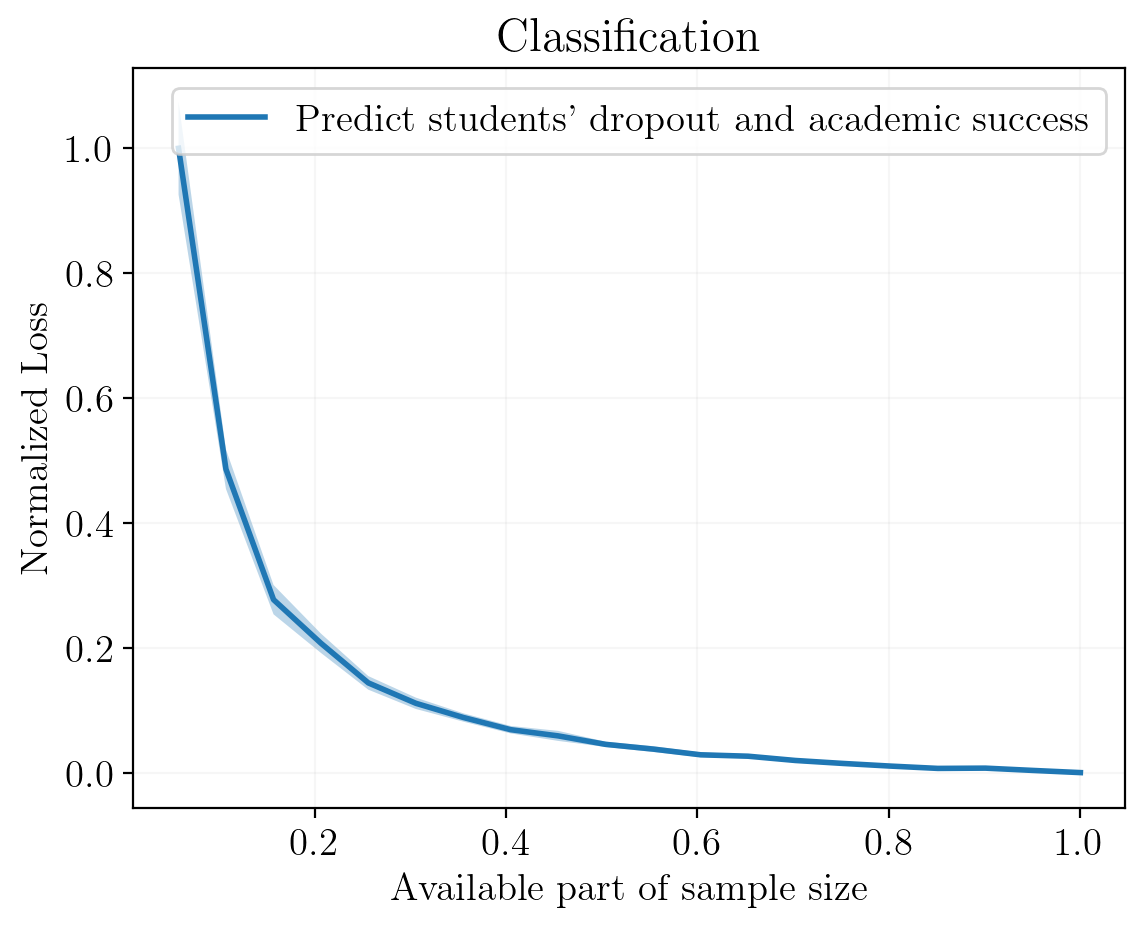

In [192]:
x_vals = sample_sizes / max(sample_sizes)
y_means = loss_means - min(loss_means)
y_means = y_means / max(y_means)
y_stds = loss_stds / max(loss_means)
#plt.plot(sample_sizes, loss_means, label=name)
#plt.fill_between(sample_sizes, loss_means - loss_stds, loss_means + loss_stds, alpha=0.3)
plt.plot(x_vals, y_means, label=data.metadata.name)
plt.fill_between(x_vals, y_means - y_stds, y_means + y_stds, alpha=0.3)

plt.legend()
plt.title("Classification")
plt.xlabel("Available part of sample size")
plt.ylabel("Normalized Loss")
#plt.xlim(left=55)
#plt.ylim(bottom=0, top=10000)
plt.show()

Теперь построим график для каждого датасета с задачей регрессии

In [197]:
import warnings
warnings.filterwarnings('ignore')

In [224]:
results_classification = {}

for key in tqdm(datasets_classification.keys()):
    
    # ==========================
    data = fetch_ucirepo(id=key)
    # ==========================
    df = data.variables[['name', 'role', 'type']]
    target = df[df.role == 'Target'].name.values[0]
    columns = df[df.role == 'Feature'][['name', 'type']]
    num_columns = columns.loc[(columns.type == 'Continuous') | (columns.type == 'Integer')].name.values
    cat_columns = columns.loc[(columns.type == 'Categorical') | (columns.type == 'Binary')].name.values
    columns = columns.name.values
        
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
        ]
    )
        
    pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('logreg', LogisticRegression())
        ]
    )

    df = data.data.original

    if data.metadata.has_missing_values:
        df = df.dropna(ignore_index=True)

    X = df.drop(columns=[target])
    y = df[target].to_numpy().flatten()
        
    dataset = Dataset(X, y, task='classification')
    m, n = X.shape
    start = max(n+1, len(dataset.labels)+1)
    sample_sizes = np.linspace(start, m, 21, dtype=int)[1:]
    B = 100

    model = pipe
    loss = log_loss

    loss_means = []
    loss_stds = []

    for k in sample_sizes:
        tmp = []
        for _ in range(B):
            X_k, y_k = dataset.sample(k)
            model.fit(X_k, y_k)
            y_pred = model.predict_proba(X)
            tmp.append(loss(y, y_pred, labels=dataset.labels))
        tmp = np.array(tmp)
        loss_means.append(tmp.mean())
        loss_stds.append(tmp.std())

    loss_means = np.array(loss_means)
    loss_stds = np.array(loss_stds)

    results_classification[data.metadata.name] = {}
    results_classification[data.metadata.name]['sample_sizes'] = sample_sizes
    results_classification[data.metadata.name]['mean'] = loss_means
    results_classification[data.metadata.name]['std'] = loss_stds

100%|██████████| 12/12 [07:41<00:00, 38.46s/it]


In [ ]:
#results_classification = load_object("plots/datasets_classification.pkl")

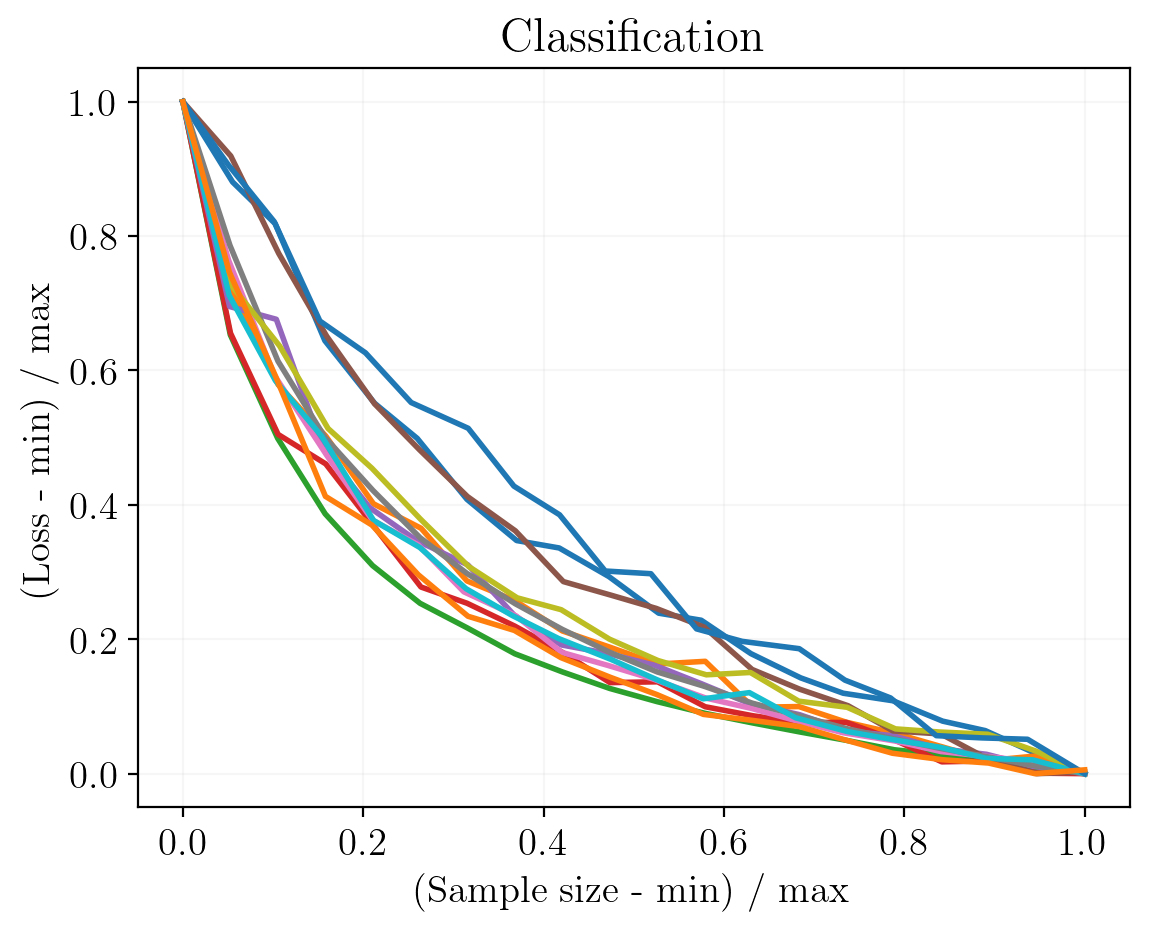

In [231]:
for name in results_classification.keys():
    sample_sizes = results_classification[name]['sample_sizes']
    loss_means = results_classification[name]['mean']
    loss_stds = results_classification[name]['std']
    x_vals = sample_sizes - min(sample_sizes)
    x_vals = x_vals / max(x_vals)
    y_means = loss_means - min(loss_means)
    y_means = y_means / max(y_means)
    y_stds = loss_stds / max(loss_means)
    #plt.plot(sample_sizes / max(sample_sizes), loss_means, label=name)
    #plt.fill_between(sample_sizes / max(sample_sizes), loss_means - loss_stds, loss_means + loss_stds, alpha=0.3)
    plt.plot(x_vals, y_means, label=name)
    plt.fill_between(x_vals, y_means - y_stds, y_means + y_stds, alpha=0.3)

#plt.legend()
plt.title("Classification")
#plt.xlabel("Available part of sample size")
#plt.ylabel("Loss")
plt.xlabel("(Sample size - min) / max")
plt.ylabel("(Loss - min) / max")
#plt.xlim(left=55)
#plt.ylim(bottom=0, top=10000)
#plt.savefig("figures/datasets_classification_stds.pdf", bbox_inches='tight')
plt.show()

In [228]:
#save_object(results_classification, "plots/datasets_classification.pkl")